## Setup

In [1]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
!pwd

/Users/nicholasbeaudoin/Desktop/Kaggle/Disaster Tweets


## Load data

In [3]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Sample disaster tweet

In [5]:
train_df[train_df['target'] == 1].values[1][3]

'Forest fire near La Ronge Sask. Canada'

Sample non-disaster tweet

In [6]:
train_df[train_df['target'] == 0].values[1][3]

'I love fruits'

## EDA

Look at the length of tweets.

In [7]:
# Create length of tweet feature
train_df['char_length'] = train_df['text'].str.len()
train_df.head()

,id,keyword,location,text,target,char_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [8]:
# Create word length feature
train_df['word_length'] = train_df['text'].str.split().str.len()
train_df.head()

,id,keyword,location,text,target,char_length,word_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16


In [9]:
# Compare the number of words between disaster and non-disaster tweets
import seaborn as sns
import matplotlib.pyplot as plt

non_disaster = train_df[train_df['target'] == 0]['word_length']
disaster = train_df[train_df['target'] == 1]['word_length']


fig = plt.figure(figsize=(10,6))

g = sns.distplot(non_disaster, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

g = sns.distplot(disaster, hist=True, kde=True, 
             bins=int(180/5), color = 'darkred', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4})

fig.legend(labels=['non-disaster','disaster'])
g.set_title('Tweet Word Count')
plt.show()

<Figure size 1000x600 with 1 Axes>

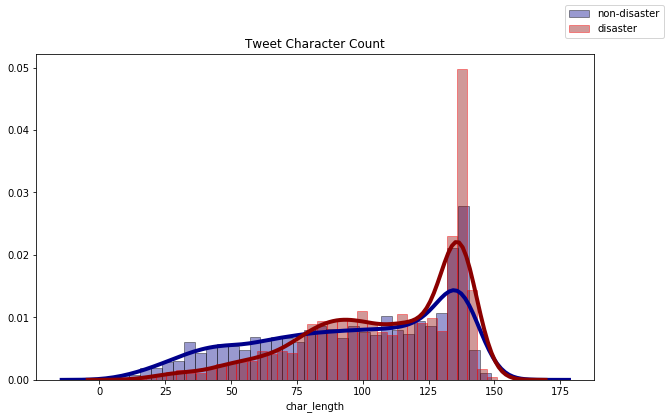

In [10]:
# Compare the length of tweets between disaster and non-disaster 
import seaborn as sns
import matplotlib.pyplot as plt

non_disaster = train_df[train_df['target'] == 0]['char_length']
disaster = train_df[train_df['target'] == 1]['char_length']


fig = plt.figure(figsize=(10,6))

g = sns.distplot(non_disaster, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

g = sns.distplot(disaster, hist=True, kde=True, 
             bins=int(180/5), color = 'darkred', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4})

fig.legend(labels=['non-disaster','disaster'])
g.set_title('Tweet Character Count')
plt.show()

There doesn't appear to be a any difference between disaster and non-disaster tweet lengths and character counts.

Let's next look at the top words in disaster tweets compared to non-disasters

In [93]:
# https://www.kaggle.com/octaviosantana/most-frequent-words

import nltk
import string

def top_n(target):
    
    # Convert text to lowercase
    text = train_df[train_df['target'] == target]['text'].str.lower()

    # Converting into a arrays
    text_list = text.values.tolist()

    # Breaking all comments by words for each list
    text_tokens = [nltk.tokenize.wordpunct_tokenize(text) for text in text_list]

    # Delete all common English words
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.append('http')
    stopwords.append('https')

    # Delete repeated characters in words, for example looooooong -> long
    from itertools import groupby

    def clear_multiple_char(comment):        
        ti = []
        for words in comment:
            t = [''.join(["".join(i) for i, _ in groupby(word)]) if len(word)>10 else word for word in words]
            ti.append(t)
        return ti

    text_tokens = clear_multiple_char(text_tokens)

    # Eliminate punctuations, numbers and reduce words by their root
    from nltk.stem.lancaster import LancasterStemmer
    stemmer = LancasterStemmer()
    punctuation = string.punctuation   # '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

    # Add numbers
    punctuation += '0123456789'

    def comment_raiz(comment):
        text = []
        for lista in comment:
            valids = [stemmer.stem(word) for word in lista if word not in stopwords and word not in punctuation 
                      and len(word)>2]
            valids_true = [''.join([char for char in word if char not in punctuation]) for word in valids if 
                           len(''.join([char for char in word if char not in punctuation]))>0]
            text.append(valids_true)
        return text

    text_tokens = comment_raiz(text_tokens)

    # Function that counts the number of times each word was used in the comments
    def counter(comment_clear):
        cnt = Counter()
        for words in comment_clear:
            for word in words:
                cnt[word] += 1
        return cnt

    # Count words
    text_tokens_cnt = counter(text_tokens)

    # Top 10
    print(text_tokens_cnt.most_common(10))

In [102]:
# disaster tweets
print('Disaster tweets')
top_n(1)

print('     ')

# non-disaster tweets
print('Non-disaster tweets')
top_n(0)

Disaster tweets
[('fir', 273), ('bomb', 247), ('new', 197), ('kil', 165), ('amp', 135), ('flood', 122), ('disast', 121), ('via', 121), ('californ', 117), ('crash', 115)]
     
Non-disaster tweets
[('lik', 309), ('new', 227), ('get', 223), ('amp', 209), ('on', 137), ('lov', 127), ('body', 119), ('bag', 113), ('com', 110), ('tim', 106)]


## Basic topic modelling

In [128]:
### https://github.com/nbeaudoin/DAT5/blob/master/notebooks/14_nlp.ipynb

import lda # Latent Dirichlet Allocation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def topic_model(target):

    target = target
    
    text = train_df[train_df['target']==target]['text']

    # Tokenize into sentences
    sentences = []
    for text in text:
        for sent in nltk.sent_tokenize(text):
            sentences.append(sent)
    sentences[:10]  

    # Tokenize into words
    tokens = []
    for text in sentences:
        for word in nltk.word_tokenize(text):
            tokens.append(word)
    tokens[:10]

    # Only keep tokens that start with a letter (using regular expressions)
    import re
    clean_tokens = [token for token in tokens if re.search('^[a-zA-Z]+', token)]
    clean_tokens[:20] # Tokenize into words

    # Initialize stemmer
    from nltk.stem.snowball import SnowballStemmer
    stemmer = SnowballStemmer('english')

    # Stem the tokens
    stemmed_tokens = [stemmer.stem(t) for t in clean_tokens]

    # Initialize lemmatizer
    lemmatizer = nltk.WordNetLemmatizer()

    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(t).lower() for t in clean_tokens] 

    # View the list of stopwords
    stopwords = nltk.corpus.stopwords.words('english')

    # Add 'http' and 'https'
    stopwords.append('http')
    stopwords.append('https')

    # Stem the stopwords
    stemmed_stops = [stemmer.stem(t) for t in stopwords]

    # Remove stopwords from stemmed tokens
    stemmed_tokens_no_stop = [stemmer.stem(t) for t in stemmed_tokens if t not in stemmed_stops]

    # Remove stopwords from cleaned tokens
    clean_tokens_no_stop = [t.lower() for t in clean_tokens if t.lower() not in stopwords]

    # Instantiate a count vectorizer with two additional parameters
    vect = CountVectorizer(stop_words='english', ngram_range=[1,3]) 
    sentences_train = vect.fit_transform(np.array(clean_tokens_no_stop))

    # Instantiate an LDA model
    model = lda.LDA(n_topics=10, n_iter=500)
    model.fit(sentences_train) # Fit the model 
    n_top_words = 10
    topic_word = model.topic_word_
    for i, topic_dist in enumerate(topic_word):
        topic_words = np.array(vect.get_feature_names())[np.argsort(topic_dist)][:-n_top_words:-1]
        print('Topic {}: {}'.format(i+1, ', '.join(topic_words)))

In [129]:
# Topic model for disaster tweets
topic_model(1)

INFO:lda:n_documents: 30791
INFO:lda:vocab_size: 8710
INFO:lda:n_words: 29655
INFO:lda:n_topics: 10
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -358384
INFO:lda:<10> log likelihood: -289651
INFO:lda:<20> log likelihood: -285943
INFO:lda:<30> log likelihood: -284748
INFO:lda:<40> log likelihood: -284204
INFO:lda:<50> log likelihood: -284191
INFO:lda:<60> log likelihood: -284105
INFO:lda:<70> log likelihood: -283787
INFO:lda:<80> log likelihood: -283659
INFO:lda:<90> log likelihood: -283549
INFO:lda:<100> log likelihood: -283272
INFO:lda:<110> log likelihood: -283576
INFO:lda:<120> log likelihood: -283510
INFO:lda:<130> log likelihood: -283315
INFO:lda:<140> log likelihood: -283462
INFO:lda:<150> log likelihood: -283328
INFO:lda:<160> log likelihood: -283307
INFO:lda:<170> log likelihood: -283408
INFO:lda:<180> log likelihood: -283399
INFO:lda:<190> log likelihood: -283189
INFO:lda:<200> log likelihood: -283435
INFO:lda:<210> log likelihood: -283690
INFO:lda:<220> log likelihood: -

Topic 1: buildings, bomber, news, fatal, watch, near, thunderstorm, derailment, flood
Topic 2: killed, mh370, attack, bombing, home, injured, floods, old, year
Topic 3: california, nuclear, crash, years, rt, earthquake, world, say, ca
Topic 4: suicide, like, storm, û_, city, confirmed, weather, affected, lives
Topic 5: news, train, latest, warning, spill, wreckage, wild, bridge, report
Topic 6: families, video, pm, typhoon, water, severe, evacuation, outbreak, people
Topic 7: amp, northern, legionnaires, bomb, ûªs, death, island, pkk, wounded
Topic 8: police, emergency, accident, û_, collapse, mass, new, oil, dead
Topic 9: disaster, hiroshima, fires, car, homes, today, forest, man, atomic
Topic 10: people, wildfire, burning, japan, debris, obama, army, area, investigators


In [130]:
# Topic model for non-disaster
topic_model(0)

INFO:lda:n_documents: 37502
INFO:lda:vocab_size: 11732
INFO:lda:n_words: 34866
INFO:lda:n_topics: 10
INFO:lda:n_iter: 500
/Users/nicholasbeaudoin/anaconda3/lib/python3.7/site-packages/lda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:lda:<0> log likelihood: -435436
INFO:lda:<10> log likelihood: -357442
INFO:lda:<20> log likelihood: -354306
INFO:lda:<30> log likelihood: -352453
INFO:lda:<40> log likelihood: -352246
INFO:lda:<50> log likelihood: -352105
INFO:lda:<60> log likelihood: -352151
INFO:lda:<70> log likelihood: -351828
INFO:lda:<80> log likelihood: -351942
INFO:lda:<90> log likelihood: -351793
INFO:lda:<100> log likelihood: -351756
INFO:lda:<110> log likelihood: -351600
INFO:lda:<120> log likelihood: -351925
INFO:lda:<130> log likelihood: -351916
INFO:lda:<140> log likelihood:

Topic 1: û_, let, reddit, know, read, content, fall, deluge, blazing
Topic 2: people, got, man, make, best, panic, ûªs, bloody, police
Topic 3: time, going, think, na, way, bags, im, fucking, come
Topic 4: world, burning, god, today, check, coming, sinking, military, stop
Topic 5: like, black, look, school, getting, harm, bad, twister, disaster
Topic 6: video, emergency, û_, great, shit, smoke, long, crush, war
Topic 7: amp, new, like, body, want, bag, cross, storm, head
Topic 8: love, day, need, life, liked, watch, home, said, sunk
Topic 9: lol, rt, work, really, help, feel, ca, night, explode
Topic 10: youtube, gt, good, news, say, right, wreck, year, blood


The above topic model allows us to determine that disaster and non-disaster tweets vary widely. The first topic for non-disaster has only one word that could be construed as being a disaste - "blazing." However, the first topic on the disaster tweets has almost every word being aligned with a disaster.

## Data split

In [22]:
# create feature/target variable
X = train_df['text']
y = train_df['target']

In [26]:
from sklearn.model_selection import train_test_split

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Vectorization

Trying to create a model that can take an input text and determine if disaster or non-disaster tweet.

- Instantiate vectorizer
- Fit vocabulary
- Transform vocab to vector space (document term matrix - DTM)


In [32]:
# instantiate
vect = CountVectorizer()

# fit
vect.fit(X_train)

# transform to DTM
X_train_dtm = vect.transform(X_train)
X_train_dtm

<5100x16398 sparse matrix of type '<class 'numpy.int64'>'
	with 74814 stored elements in Compressed Sparse Row format>

In [33]:
# transform testing data (using fitted vocabulary) into a document-term matrix (DON'T USE .FIT ON TEST DATA!!!)
X_test_dtm = vect.transform(X_test)
X_test_dtm

<2513x16398 sparse matrix of type '<class 'numpy.int64'>'
	with 31076 stored elements in Compressed Sparse Row format>

## Modelling

- split test/train
- import
- instantiate
- fit
- predict

In [34]:
# import
from sklearn.naive_bayes import MultinomialNB

# instantiate
nb = MultinomialNB()

# fit
nb.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [36]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [37]:
# calculate accuracy of class predictions
from sklearn import metrics

print(metrics.accuracy_score(y_test, y_pred_class))

0.8026263430163152


In [38]:
# confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[1263  183]
 [ 313  754]]


In [39]:
# print out the classification table
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1446
           1       0.80      0.71      0.75      1067

   micro avg       0.80      0.80      0.80      2513
   macro avg       0.80      0.79      0.79      2513
weighted avg       0.80      0.80      0.80      2513



In [43]:
# print messages text for the false positives
X_test[y_test < y_pred_class][:10]

6029    ON THE USE OF PERFORATED METAL SHEAR PANEL SFO...
4019    Who is bringing the tornadoes and floods. Who ...
1511    @MyVintageSoul ...of the British upper class a...
6372                                 she's a suicide bomb
3753    Dear @CanonUSAimaging I brought it ;) #CanonBr...
4359    Remove the http://t.co/Xxj2B4JxRt and Linkury ...
3771    When your heart is bigger than the obstacles  ...
4928    Magic City Mayhem: Kissimmee adventures ? Aug....
3003    Dust devil maintenance fee - buy up la rotary ...
2111    New crime: knowing your rights. Punishable by ...
Name: text, dtype: object

In [45]:
# print messages text for the false negatives
X_test[y_test > y_pred_class][:10]

2644    So you have a new weapon that can cause un-ima...
1765    my favorite lady came to our volunteer meeting...
1817    @brianroemmele UX fail of EMV - people want to...
3044    Nepal earthquake 3 months on: Women fear abuse...
5324    Pandemonium In Aba As Woman Delivers Baby With...
6539    It's a miracle that mankind survived 70 years ...
4518    @pattonoswalt @FoxNews Wait I thought Fecal Hu...
230     @PhilipDuncan @breakfastone People 'annihilate...
6292    TodayÛªs storm will pass; let tomorrowÛªs li...
4320    Hellfire! We donÛªt even want to think about ...
Name: text, dtype: object

## Submission

In [43]:
sample_submission = pd.read_csv("data/sample_submission.csv")

In [44]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [45]:
sample_submission["target"] = clf.predict(test_vectors)

In [46]:
sample_submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [47]:
sample_submission.to_csv("data/submission.csv", index=False)